In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

## 11.1 Data Preparation

In [16]:
df_R = pd.read_csv('ratings.csv')
df_M = pd.read_csv('movies.csv')

***Read data from 2 files***

In [17]:
df = pd.merge(df_R,df_M)

***Join dataframe rating and movie***

In [18]:
df

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
...,...,...,...,...,...,...
25000090,162358,200192,2.0,1553453039,Den frusna leoparden (1986),(no genres listed)
25000091,162358,200194,2.0,1553453843,Tough Luck (2004),Action|Adventure|Thriller
25000092,162386,139970,3.5,1549215965,I Don't Speak English (1995),Comedy
25000093,162386,200726,4.0,1554651417,The Graduates (1995),Children|Drama


In [19]:
df_train, df_val = train_test_split(df, train_size=0.007, test_size=0.003, stratify=df['rating'])

***Preapare Train, validation data***

In [20]:
userId_list = list(set(df['userId']))
index = 0
dict_users = {}
for ids in sorted(userId_list):
    dict_users.update({ids : index})
    index += 1

***Re-numbering userId ( to eliminate skipping id)***

In [21]:
movieId_list = list(set(df['movieId']))
index = 0
dict_movies = {}
for ids in sorted(movieId_list):
    dict_movies.update ({ids : index})
    index += 1

***Re-numbering movieId***

In [22]:
df_train["userId"] = df_train["userId"].map(dict_users)
df_train["movieId"] = df_train["movieId"].map(dict_movies)
df_val["userId"] = df_val["userId"].map(dict_users)
df_val["movieId"] = df_val["movieId"].map(dict_movies)

***Map new id to train, validation for both “userId”, “movieId”***

In [23]:
num_unique_users = len(userId_list)
num_unique_movies = len(movieId_list)

## 1.2 Model Preparation and Training

In [24]:
EMBEDDING_SIZE=100
users_input = Input(shape=(1,), name="users_input")
users_embedding = Embedding(num_unique_users + 1, EMBEDDING_SIZE,name="users_embeddings")(users_input)
users_bias = Embedding(num_unique_users + 1, 1, name="users_bias")(users_input)

movies_input = Input(shape=(1,), name="movies_input")
movies_embedding = Embedding(num_unique_movies + 1, EMBEDDING_SIZE,name="movies_embeddings")(movies_input)
movies_bias = Embedding(num_unique_movies + 1, 1, name="movies_bias")(movies_input)

dot_product_users_movies = tf.math.multiply(users_embedding, movies_embedding)
input_terms = dot_product_users_movies + users_bias + movies_bias
input_terms = Flatten(name="fl_inputs")(input_terms)
output = Dense(1, activation="relu", name="output")(input_terms)
model = Model(inputs=[users_input, movies_input], outputs=output)

opt_adam = Adam(lr = 0.005)
model.compile(optimizer=opt_adam, loss= ['mse'], metrics=['mean_absolute_error'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


***Create Model NCF***

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 users_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 movies_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 users_embeddings (Embedding)   (None, 1, 100)       16254200    ['users_input[0][0]']            
                                                                                                  
 movies_embeddings (Embedding)  (None, 1, 100)       5904800     ['movies_input[0][0]']           
                                                                                            

***View Model Summary***

In [26]:
BS = 2048     #[64, 128, 256, 512, 1024, 2048]  # try at least 3 values
EP = 10       #[5, 10, 20, 50, 60]              # try at least 3 values

history = model.fit(x=[df_train.userId, df_train.movieId], y=df_train.rating, batch_size=BS, epochs=EP, verbose=1, validation_data=([df_val.userId, df_val.movieId], df_val.rating))

Epoch 1/10


2022-11-24 16:32:29.816026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 5.3306 - mean_absolute_error: 1.8748

2022-11-24 16:32:35.571382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 7s 64ms/step - loss: 5.3306 - mean_absolute_error: 1.8748 - val_loss: 1.8116 - val_mean_absolute_error: 1.0504
Epoch 2/10
86/86 [==============================] - 4s 42ms/step - loss: 1.1513 - mean_absolute_error: 0.8187 - val_loss: 1.4444 - val_mean_absolute_error: 0.9305
Epoch 3/10
86/86 [==============================] - 3s 39ms/step - loss: 0.6077 - mean_absolute_error: 0.5775 - val_loss: 1.4018 - val_mean_absolute_error: 0.9142
Epoch 4/10
86/86 [==============================] - 3s 36ms/step - loss: 0.3328 - mean_absolute_error: 0.4141 - val_loss: 1.3990 - val_mean_absolute_error: 0.9130
Epoch 5/10
86/86 [==============================] - 3s 34ms/step - loss: 0.1787 - mean_absolute_error: 0.3012 - val_loss: 1.4080 - val_mean_absolute_error: 0.9189
Epoch 6/10
86/86 [==============================] - 3s 32ms/step - loss: 0.1272 - mean_absolute_error: 0.2472 - val_loss: 1.3956 - val_mean_absolute_error: 0.9145
Epoch 7/10
86/86 [===============

***Training Model***

## 11.3 Model Performance Evaluation

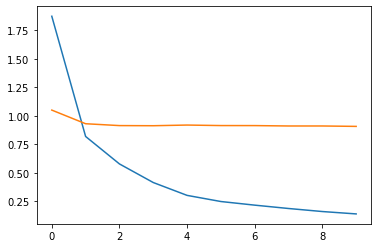

In [27]:
plt.plot(history.history["mean_absolute_error"])
plt.plot(history.history["val_mean_absolute_error"])

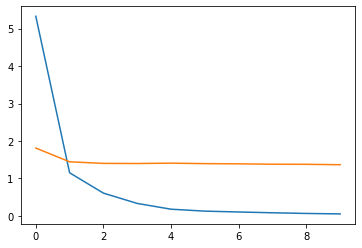

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

***Visualize loss***

In [29]:
# userPredictR = pd.DataFrame(model.predict([df_val.userId, df_val.movieId]))

***Model Prediction***